# 🎓 KNN Methods and Engines in OpenSearch: Complete Guide

Welcome to the comprehensive guide on KNN (K-Nearest Neighbors) methods and engines in OpenSearch!

This notebook explores:
- **Methods**: HNSW (Hierarchical Navigable Small World) and IVF (Inverted File Index)
- **Engines**: Faiss, Lucene, and NMSLIB (deprecated)
- **Practical applications**: How to choose, configure, and optimize for your use case

## 📚 Quick Reference

```mermaid
graph LR
    A["🎯 KNN Vector Search"] --> B["📐 Methods"]
    A --> C["⚙️ Engines"]
    
    B --> B1["HNSW<br/>Graph-based<br/>Good latency"]
    B --> B2["IVF<br/>Bucket-based<br/>Better memory"]
    
    C --> C1["Faiss<br/>Advanced<br/>Large-scale"]
    C --> C2["Lucene<br/>Native<br/>Smart filter"]
    C --> C3["NMSLIB<br/>Deprecated<br/>Legacy"]
    
    style A fill:#FF6B6B,color:#fff
    style B fill:#4ECDC4,color:#fff
    style C fill:#45B7D1,color:#fff
    style B1 fill:#E8F5E9,color:#000
    style B2 fill:#E8F5E9,color:#000
    style C1 fill:#FFF3E0,color:#000
    style C2 fill:#FFF3E0,color:#000
    style C3 fill:#FFEBEE,color:#000
```


## Section 1: Import Required Libraries


In [1]:
from opensearchpy import OpenSearch
from opensearchpy.helpers import bulk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys, os
from typing import Dict, List, Tuple

# For visualizations
import seaborn as sns
from datetime import datetime

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

print("✓ All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


✓ All libraries imported successfully!
NumPy version: 2.3.3
Pandas version: 2.2.3


## Section 2: Connect to OpenSearch


In [2]:
IS_AUTH = True
HOST = 'localhost'
PORT = 9200

if IS_AUTH:
    # Initialize the OpenSearch client with authentication
    client = OpenSearch(
        hosts=[{'host': HOST, 'port': PORT}],
        http_auth=('admin', 'Developer@123'),  # Replace with your credentials
        use_ssl=True,
        verify_certs=False,
        ssl_show_warn=False
    )
else:
    # Initialize the OpenSearch client without authentication
    client = OpenSearch(
        hosts=[{'host': HOST, 'port': PORT}],
        use_ssl=False,
        verify_certs=False,
        ssl_assert_hostname=False,
        ssl_show_warn=False
    )

# Test the connection
try:
    info = client.info()
    print("✓ Successfully connected to OpenSearch!")
    print(f"  Cluster: {info['cluster_name']}")
    print(f"  Version: {info['version']['number']}")
except Exception as e:
    print(f"✗ Failed to connect: {e}")


✓ Successfully connected to OpenSearch!
  Cluster: docker-cluster
  Version: 3.3.0


## Section 3: Understanding KNN Methods

### 🎯 What is a Method?

A **method** defines the algorithm used for organizing vector data at **indexing time** and searching it at **search time**.

OpenSearch supports two main methods:

### 1️⃣ HNSW (Hierarchical Navigable Small World)

**How it works:**
- Creates a **hierarchical graph structure** of connections between vectors
- Navigates through layers starting from the top layer
- Efficient for similarity search in metric spaces

**Best for:**
- ✅ Low query latency
- ✅ High query quality
- ✅ When memory is not a concern
- ✅ General-purpose similarity search

**Trade-offs:**
- Higher memory consumption (~1.1 * (4 * dimension + 8 * m) bytes/vector)
- Slower indexing speed

**Parameters:**
- `ef_construction`: Size of dynamic list during k-NN graph creation (higher = better accuracy but slower indexing)
- `m`: Number of bidirectional links created for each element (typical: 2-100)
- `ef_search`: Size of dynamic list during k-NN searches (faiss only, higher = better accuracy but slower search)

---

### 2️⃣ IVF (Inverted File Index)

**How it works:**
- Partitions vectors into **buckets** based on clustering (k-means)
- During search, only searches a **subset of buckets**
- More efficient memory usage

**Best for:**
- ✅ Less memory than HNSW
- ✅ Faster indexing
- ✅ Large-scale deployments
- ✅ When memory is a concern

**Trade-offs:**
- Requires **training step** before indexing
- Query quality may be lower than HNSW
- Only available in Faiss engine

**Parameters:**
- `nlist`: Number of buckets/partitions (higher = more memory but better accuracy)
- `nprobes`: Number of buckets to search (higher = better accuracy but slower search)
- `encoder`: Optional encoding method (flat, pq, sq) for further compression

---

### Comparison Table

| Aspect | HNSW | IVF |
|--------|------|-----|
| **Algorithm** | Graph-based hierarchical | Bucket-based partitioning |
| **Memory** | High | Medium |
| **Indexing Speed** | Slower | Faster |
| **Query Quality** | Better | Good |
| **Training Required** | No | Yes |
| **Scalability** | Tens of billions | Tens of billions |
| **Available In** | All engines | Faiss only |



In [3]:
# Method Configuration Examples

print("=" * 80)
print("HNSW METHOD CONFIGURATION EXAMPLES")
print("=" * 80)

hnsw_example_faiss = {
    "name": "hnsw",
    "space_type": "l2",
    "engine": "faiss",
    "parameters": {
        "ef_construction": 256,
        "m": 16,
        "ef_search": 100
    }
}

hnsw_example_lucene = {
    "name": "hnsw",
    "space_type": "l2",
    "engine": "lucene",
    "parameters": {
        "ef_construction": 245,
        "m": 2048
    }
}

print("\n🔹 HNSW with Faiss (good for large-scale):")
print(f"{hnsw_example_faiss}")

print("\n🔹 HNSW with Lucene (good for smaller deployments):")
print(f"{hnsw_example_lucene}")

print("\n" + "=" * 80)
print("IVF METHOD CONFIGURATION EXAMPLES (Faiss only)")
print("=" * 80)

ivf_example_flat = {
    "name": "ivf",
    "space_type": "l2",
    "engine": "faiss",
    "parameters": {
        "nlist": 128,      # number of clusters
        "nprobes": 10      # number to search
    }
}

ivf_example_pq = {
    "name": "ivf",
    "space_type": "l2",
    "engine": "faiss",
    "parameters": {
        "nlist": 128,
        "nprobes": 10,
        "encoder": {
            "name": "pq",
            "parameters": {
                "m": 8,           # number of subvectors
                "code_size": 8    # bits per code
            }
        }
    }
}

print("\n🔹 IVF with Flat Encoder (good for accuracy):")
print(f"{ivf_example_flat}")

print("\n🔹 IVF with PQ Encoder (good for memory savings):")
print(f"{ivf_example_pq}")

print("\n✓ Method configurations displayed!")


HNSW METHOD CONFIGURATION EXAMPLES

🔹 HNSW with Faiss (good for large-scale):
{'name': 'hnsw', 'space_type': 'l2', 'engine': 'faiss', 'parameters': {'ef_construction': 256, 'm': 16, 'ef_search': 100}}

🔹 HNSW with Lucene (good for smaller deployments):
{'name': 'hnsw', 'space_type': 'l2', 'engine': 'lucene', 'parameters': {'ef_construction': 245, 'm': 2048}}

IVF METHOD CONFIGURATION EXAMPLES (Faiss only)

🔹 IVF with Flat Encoder (good for accuracy):
{'name': 'ivf', 'space_type': 'l2', 'engine': 'faiss', 'parameters': {'nlist': 128, 'nprobes': 10}}

🔹 IVF with PQ Encoder (good for memory savings):
{'name': 'ivf', 'space_type': 'l2', 'engine': 'faiss', 'parameters': {'nlist': 128, 'nprobes': 10, 'encoder': {'name': 'pq', 'parameters': {'m': 8, 'code_size': 8}}}}

✓ Method configurations displayed!


## Section 4: Exploring KNN Engines

### ⚙️ What is an Engine?

An **engine** is the library that **implements** the methods (HNSW, IVF). Different engines can implement the same method with varying optimizations.

OpenSearch supports three engines:

---

### 🟢 FAISS Engine (Facebook AI Similarity Search)

**Characteristics:**
- ✅ Advanced vector indexing capabilities
- ✅ Multiple methods (HNSW, IVF)
- ✅ Multiple encoding options (flat, pq, sq)
- ✅ GPU support available
- ✅ SIMD optimization (AVX2, AVX-512)
- ✅ Best for **large-scale use cases**

**Supported Methods:**
- HNSW: l2, innerproduct, hamming, cosinesimil
- IVF: l2, innerproduct, hamming, cosinesimil

**Best Practices:**
- Use for tens of billions of vectors
- Lowest indexing latency
- Can trade accuracy for memory with encoders

**Training Required:**
- ❌ No for HNSW
- ✅ Yes for IVF

---

### 🟦 Lucene Engine

**Characteristics:**
- ✅ Native Java implementation in OpenSearch
- ✅ Good filtering capabilities (smart filtering)
- ✅ Tight OpenSearch integration
- ✅ Post-filtering support
- ✅ Best for **smaller deployments** (< 10 million vectors)

**Supported Methods:**
- HNSW: l2, cosinesimil, innerproduct (2.13+)

**Best Practices:**
- Use for smaller deployments
- Better filtering performance
- Lower memory overhead for small datasets

**Training Required:**
- ❌ No

---

### 🔴 NMSLIB Engine (Deprecated)

**Status:** ⚠️ **DEPRECATED IN OpenSearch 3.0.0+**

**Characteristics:**
- Legacy Non-Metric Space Library
- Previous default engine
- Still works but not recommended

**Supported Methods:**
- HNSW: l2, innerproduct, cosinesimil, l1, linf

**Migration Path:**
- ➡️ Migrate to **Faiss** for large-scale
- ➡️ Migrate to **Lucene** for small-scale

---

### Engine Comparison Matrix

| Feature | Faiss | Lucene | NMSLIB |
|---------|-------|--------|--------|
| **Max Dimensions** | 16,000 | 16,000 | 16,000 |
| **Methods** | HNSW, IVF | HNSW only | HNSW only |
| **Filtering** | Post-filter | Smart filter | Post-filter |
| **Training (IVF)** | Yes | N/A | N/A |
| **Max Vectors** | Tens of billions | < 10M | Tens of billions |
| **Indexing Latency** | Low | Low | Low |
| **Query Latency** | Low | High | Low |
| **Memory** | High (can reduce with encoders) | High | High |
| **GPU Support** | Yes | No | No |
| **Status** | ✅ Active | ✅ Active | ⚠️ Deprecated |



In [4]:
# Engine Support Matrix

print("=" * 100)
print("SUPPORTED METHOD-ENGINE COMBINATIONS AND SPACE TYPES")
print("=" * 100)

engine_support = {
    "FAISS": {
        "HNSW": ["l2", "innerproduct", "hamming", "cosinesimil"],
        "IVF": ["l2", "innerproduct", "hamming", "cosinesimil"],
        "Training": "Not needed for HNSW, Required for IVF",
        "Max Vectors": "Tens of billions",
        "Best For": "Large-scale, GPU support available"
    },
    "LUCENE": {
        "HNSW": ["l2", "cosinesimil", "innerproduct (2.13+)"],
        "IVF": "Not supported",
        "Training": "Not needed",
        "Max Vectors": "< 10 million",
        "Best For": "Smaller deployments, smart filtering"
    },
    "NMSLIB (Deprecated)": {
        "HNSW": ["l2", "innerproduct", "cosinesimil", "l1", "linf"],
        "IVF": "Not supported",
        "Training": "Not needed",
        "Max Vectors": "Tens of billions",
        "Best For": "Legacy systems (not recommended)"
    }
}

for engine, info in engine_support.items():
    print(f"\n{'=' * 100}")
    print(f"🔧 {engine}")
    print(f"{'=' * 100}")
    for key, value in info.items():
        if isinstance(value, list):
            print(f"  {key}: {', '.join(value)}")
        else:
            print(f"  {key}: {value}")

print("\n" + "=" * 100)
print("DECISION TREE: CHOOSING AN ENGINE")
print("=" * 100)

decision_tree = """
START: Do you have < 10 million vectors?
  │
  ├─→ YES: Do you need advanced filtering?
  │        ├─→ YES: Use LUCENE ✓
  │        └─→ NO: Use FAISS or LUCENE (Faiss for more features)
  │
  └─→ NO (> 10 million): Do you need IVF for memory savings?
           ├─→ YES: Use FAISS with IVF ✓
           ├─→ NO: Use FAISS with HNSW ✓
           └─→ GPU available: Use FAISS (best performance) ✓
"""

print(decision_tree)


SUPPORTED METHOD-ENGINE COMBINATIONS AND SPACE TYPES

🔧 FAISS
  HNSW: l2, innerproduct, hamming, cosinesimil
  IVF: l2, innerproduct, hamming, cosinesimil
  Training: Not needed for HNSW, Required for IVF
  Max Vectors: Tens of billions
  Best For: Large-scale, GPU support available

🔧 LUCENE
  HNSW: l2, cosinesimil, innerproduct (2.13+)
  IVF: Not supported
  Training: Not needed
  Max Vectors: < 10 million
  Best For: Smaller deployments, smart filtering

🔧 NMSLIB (Deprecated)
  HNSW: l2, innerproduct, cosinesimil, l1, linf
  IVF: Not supported
  Training: Not needed
  Max Vectors: Tens of billions
  Best For: Legacy systems (not recommended)

DECISION TREE: CHOOSING AN ENGINE

START: Do you have < 10 million vectors?
  │
  ├─→ YES: Do you need advanced filtering?
  │        ├─→ YES: Use LUCENE ✓
  │        └─→ NO: Use FAISS or LUCENE (Faiss for more features)
  │
  └─→ NO (> 10 million): Do you need IVF for memory savings?
           ├─→ YES: Use FAISS with IVF ✓
           ├─→ NO: 

## Section 5: Creating Indices with Different Methods and Engines

We'll create multiple indices to demonstrate different configurations.


In [5]:
def create_index_mapping(method_name: str, engine: str, space_type: str, 
                        dimension: int = 256, **method_params) -> Dict:
    """
    Create a KNN index mapping with specified method and engine.
    
    Args:
        method_name: 'hnsw' or 'ivf'
        engine: 'faiss' or 'lucene'
        space_type: 'l2', 'cosinesimil', 'innerproduct', etc.
        dimension: Vector dimension (default 256 for demo)
        **method_params: Additional method-specific parameters
    
    Returns:
        Index mapping dictionary
    """
    mapping = {
        "settings": {
            "index": {
                "knn": True,
                "knn.algo_param.ef_search": 100
            },
            "number_of_shards": 1,
            "number_of_replicas": 0
        },
        "mappings": {
            "properties": {
                "vector_field": {
                    "type": "knn_vector",
                    "dimension": dimension,
                    "method": {
                        "name": method_name,
                        "engine": engine,
                        "space_type": space_type,
                        "parameters": method_params
                    }
                },
                "document_id": {"type": "integer"},
                "label": {"type": "keyword"},
                "description": {"type": "text"}
            }
        }
    }
    return mapping

# Configuration for our test indices
index_configs = [
    {
        "name": "knn-faiss-hnsw-l2",
        "method": "hnsw",
        "engine": "faiss",
        "space_type": "l2",
        "params": {
            "ef_construction": 128,
            "m": 16,
            "ef_search": 100
        },
        "description": "Faiss HNSW with L2 distance"
    },
    {
        "name": "knn-faiss-hnsw-cosinesimil",
        "method": "hnsw",
        "engine": "faiss",
        "space_type": "cosinesimil",
        "params": {
            "ef_construction": 128,
            "m": 16,
            "ef_search": 100
        },
        "description": "Faiss HNSW with Cosine Similarity"
    },
    {
        "name": "knn-lucene-hnsw-l2",
        "method": "hnsw",
        "engine": "lucene",
        "space_type": "l2",
        "params": {
            "ef_construction": 128,
            "m": 16
        },
        "description": "Lucene HNSW with L2 distance"
    },
    {
        "name": "knn-lucene-hnsw-cosinesimil",
        "method": "hnsw",
        "engine": "lucene",
        "space_type": "cosinesimil",
        "params": {
            "ef_construction": 128,
            "m": 16
        },
        "description": "Lucene HNSW with Cosine Similarity"
    }
]

print("=" * 100)
print("CREATING KNN INDICES WITH DIFFERENT CONFIGURATIONS")
print("=" * 100)

created_indices = []

for config in index_configs:
    index_name = config["name"]
    
    try:
        # Check if index exists
        if client.indices.exists(index=index_name):
            client.indices.delete(index=index_name)
            print(f"  Deleted existing index: {index_name}")
        
        # Create mapping
        mapping = create_index_mapping(
            method_name=config["method"],
            engine=config["engine"],
            space_type=config["space_type"],
            dimension=256,
            **config["params"]
        )
        
        # Create index
        client.indices.create(index=index_name, body=mapping)
        created_indices.append(config)
        
        print(f"\n✓ Created: {index_name}")
        print(f"  Description: {config['description']}")
        print(f"  Method: {config['method']} | Engine: {config['engine']} | Space: {config['space_type']}")
        print(f"  Parameters: {config['params']}")
        
    except Exception as e:
        print(f"\n✗ Failed to create {index_name}: {str(e)[:100]}")

print(f"\n{'=' * 100}")
print(f"Summary: Created {len(created_indices)} indices successfully!")
print(f"{'=' * 100}")


CREATING KNN INDICES WITH DIFFERENT CONFIGURATIONS

✓ Created: knn-faiss-hnsw-l2
  Description: Faiss HNSW with L2 distance
  Method: hnsw | Engine: faiss | Space: l2
  Parameters: {'ef_construction': 128, 'm': 16, 'ef_search': 100}

✓ Created: knn-faiss-hnsw-cosinesimil
  Description: Faiss HNSW with Cosine Similarity
  Method: hnsw | Engine: faiss | Space: cosinesimil
  Parameters: {'ef_construction': 128, 'm': 16, 'ef_search': 100}

✓ Created: knn-lucene-hnsw-l2
  Description: Lucene HNSW with L2 distance
  Method: hnsw | Engine: lucene | Space: l2
  Parameters: {'ef_construction': 128, 'm': 16}

✓ Created: knn-lucene-hnsw-cosinesimil
  Description: Lucene HNSW with Cosine Similarity
  Method: hnsw | Engine: lucene | Space: cosinesimil
  Parameters: {'ef_construction': 128, 'm': 16}

Summary: Created 4 indices successfully!


## Section 6: Indexing Documents with Vector Data

Now let's populate our indices with sample vector data.


In [6]:
# Generate sample vector data
np.random.seed(42)

def generate_vectors(num_vectors: int = 100, dimension: int = 256) -> List[np.ndarray]:
    """Generate random normalized vectors for testing."""
    vectors = []
    for _ in range(num_vectors):
        vector = np.random.randn(dimension)
        # Normalize vector
        vector = vector / np.linalg.norm(vector)
        vectors.append(vector)
    return vectors

# Generate vectors
sample_vectors = generate_vectors(num_vectors=150, dimension=256)
print(f"✓ Generated {len(sample_vectors)} vectors with dimension {len(sample_vectors[0])}")

# Create documents for indexing
def create_documents(vectors: List[np.ndarray], index_name: str, 
                     labels: List[str] = None) -> List[Dict]:
    """Create bulk indexing documents."""
    documents = []
    if labels is None:
        labels = [f"document_{i}" for i in range(len(vectors))]
    
    for i, vector in enumerate(vectors):
        doc = {
            "_index": index_name,
            "_id": str(i + 1),
            "_source": {
                "document_id": i + 1,
                "vector_field": vector.tolist(),
                "label": labels[i % len(labels)],
                "description": f"Sample document {i + 1}"
            }
        }
        documents.append(doc)
    
    return documents

# Index documents into all created indices
print("\n" + "=" * 100)
print("INDEXING DOCUMENTS INTO ALL INDICES")
print("=" * 100)

indexing_times = {}

for config in created_indices:
    index_name = config["name"]
    
    try:
        # Create documents
        documents = create_documents(
            sample_vectors, 
            index_name,
            labels=["cluster_A", "cluster_B", "cluster_C"]
        )
        
        # Measure indexing time
        start_time = time.time()
        success, failed = bulk(client=client, actions=documents, chunk_size=100)
        indexing_time = (time.time() - start_time) * 1000  # Convert to ms
        indexing_times[index_name] = indexing_time
        
        # Refresh index
        client.indices.refresh(index=index_name)
        
        print(f"\n✓ {index_name}")
        print(f"  Indexed: {success} documents, Failed: {failed}")
        print(f"  Time: {indexing_time:.2f}ms")
        
    except Exception as e:
        print(f"\n✗ Failed to index into {index_name}: {str(e)[:100]}")

print(f"\n{'=' * 100}")
print("Indexing Complete!")
print(f"{'=' * 100}")


✓ Generated 150 vectors with dimension 256

INDEXING DOCUMENTS INTO ALL INDICES

✓ knn-faiss-hnsw-l2
  Indexed: 150 documents, Failed: []
  Time: 71.66ms

✓ knn-faiss-hnsw-cosinesimil
  Indexed: 150 documents, Failed: []
  Time: 41.56ms

✓ knn-lucene-hnsw-l2
  Indexed: 150 documents, Failed: []
  Time: 49.03ms

✓ knn-lucene-hnsw-cosinesimil
  Indexed: 150 documents, Failed: []
  Time: 48.88ms

Indexing Complete!


## Section 7: Querying with KNN Search

Now let's search against our indices and compare the results.


In [7]:
# Use a query vector (using the first vector from our generated set)
query_vector = sample_vectors[0]
k = 5  # Find top 5 nearest neighbors

print("=" * 100)
print("KNN SEARCH QUERIES ACROSS ALL INDICES")
print("=" * 100)

search_results = {}

for config in created_indices:
    index_name = config["name"]
    
    try:
        # Construct KNN query
        knn_query = {
            "size": k,
            "query": {
                "knn": {
                    "vector_field": {
                        "vector": query_vector.tolist(),
                        "k": k
                    }
                }
            }
        }
        
        # Execute search and measure time
        start_time = time.time()
        response = client.search(index=index_name, body=knn_query)
        query_time = (time.time() - start_time) * 1000  # Convert to ms
        
        # Extract results
        hits = response['hits']['hits']
        search_results[index_name] = {
            'time_ms': query_time,
            'hits': hits,
            'total': response['hits']['total']['value']
        }
        
        print(f"\n✓ {index_name}")
        print(f"  Query Time: {query_time:.2f}ms")
        print(f"  Total Documents: {search_results[index_name]['total']}")
        print(f"  Top {k} Results:")
        
        for i, hit in enumerate(hits):
            print(f"    {i+1}. Doc {hit['_id']}: Score={hit['_score']:.6f}, Label={hit['_source']['label']}")
        
    except Exception as e:
        print(f"\n✗ Search failed in {index_name}: {str(e)[:100]}")

print(f"\n{'=' * 100}")
print("Search Queries Complete!")
print(f"{'=' * 100}")


KNN SEARCH QUERIES ACROSS ALL INDICES

✓ knn-faiss-hnsw-l2
  Query Time: 8.14ms
  Total Documents: 5
  Top 5 Results:
    1. Doc 1: Score=1.000000, Label=cluster_A
    2. Doc 103: Score=0.389741, Label=cluster_A
    3. Doc 107: Score=0.375963, Label=cluster_B
    4. Doc 24: Score=0.374571, Label=cluster_C
    5. Doc 81: Score=0.371767, Label=cluster_C

✓ knn-faiss-hnsw-cosinesimil
  Query Time: 4.04ms
  Total Documents: 5
  Top 5 Results:
    1. Doc 1: Score=1.000000, Label=cluster_A
    2. Doc 103: Score=0.608548, Label=cluster_A
    3. Doc 107: Score=0.585041, Label=cluster_B
    4. Doc 24: Score=0.582570, Label=cluster_C
    5. Doc 81: Score=0.577536, Label=cluster_C

✓ knn-lucene-hnsw-l2
  Query Time: 3.59ms
  Total Documents: 5
  Top 5 Results:
    1. Doc 1: Score=1.000000, Label=cluster_A
    2. Doc 103: Score=0.389740, Label=cluster_A
    3. Doc 107: Score=0.375963, Label=cluster_B
    4. Doc 24: Score=0.374571, Label=cluster_C
    5. Doc 81: Score=0.371767, Label=cluster_C

✓ k

## Section 8: Performance Comparison and Memory Estimation

Let's analyze the performance across different configurations and estimate memory usage.


In [8]:
# Performance Analysis

print("=" * 100)
print("PERFORMANCE ANALYSIS")
print("=" * 100)

performance_data = []

for index_name, result in search_results.items():
    config = next((c for c in created_indices if c['name'] == index_name), None)
    if config:
        performance_data.append({
            'Index': index_name,
            'Engine': config['engine'],
            'Method': config['method'],
            'Space Type': config['space_type'],
            'Query Time (ms)': f"{result['time_ms']:.2f}",
            'Top Result Score': f"{result['hits'][0]['_score']:.6f}" if result['hits'] else "N/A"
        })

df_performance = pd.DataFrame(performance_data)
print("\n" + df_performance.to_string(index=False))

# Memory Estimation

print("\n\n" + "=" * 100)
print("MEMORY ESTIMATION")
print("=" * 100)

def estimate_hnsw_memory(num_vectors: int, dimension: int, m: int) -> float:
    """
    Estimate memory required for HNSW index.
    Formula: 1.1 * (4 * dimension + 8 * m) bytes/vector
    """
    return 1.1 * (4 * dimension + 8 * m) * num_vectors / (1024 ** 3)  # Convert to GB

def estimate_ivf_memory(num_vectors: int, dimension: int, nlist: int) -> float:
    """
    Estimate memory required for IVF index.
    Formula: 1.1 * (((4 * dimension) * num_vectors) + (4 * nlist * dimension)) bytes
    """
    return 1.1 * (((4 * dimension) * num_vectors) + (4 * nlist * dimension)) / (1024 ** 3)  # Convert to GB

print("\nHNSW Memory Estimation:")
print("-" * 100)

# Example: 1 million vectors, 256 dimension, m=16
num_vectors_example = 1_000_000
dimension = 256
m = 16

hnsw_memory = estimate_hnsw_memory(num_vectors_example, dimension, m)
print(f"\nFor {num_vectors_example:,} vectors with dimension={dimension}, m={m}:")
print(f"  Estimated Memory: {hnsw_memory:.2f} GB")
print(f"  Formula: 1.1 * (4 * {dimension} + 8 * {m}) * {num_vectors_example:,} = {hnsw_memory:.2f} GB")

print("\n\nIVF Memory Estimation:")
print("-" * 100)

# Example: 1 million vectors, 256 dimension, nlist=128
nlist = 128
ivf_memory = estimate_ivf_memory(num_vectors_example, dimension, nlist)
print(f"\nFor {num_vectors_example:,} vectors with dimension={dimension}, nlist={nlist}:")
print(f"  Estimated Memory: {ivf_memory:.2f} GB")
print(f"  Formula: 1.1 * (((4 * {dimension}) * {num_vectors_example:,}) + (4 * {nlist} * {dimension})) = {ivf_memory:.2f} GB")

print("\n\nMemory Comparison Table:")
print("-" * 100)

comparison_data = []
for m_val in [8, 16, 32]:
    hnsw_mem = estimate_hnsw_memory(num_vectors_example, dimension, m_val)
    comparison_data.append({
        'Configuration': f'HNSW (m={m_val})',
        'Memory (GB)': f'{hnsw_mem:.2f}',
        'Use Case': 'High quality, more memory'
    })

for nlist_val in [64, 128, 256]:
    ivf_mem = estimate_ivf_memory(num_vectors_example, dimension, nlist_val)
    comparison_data.append({
        'Configuration': f'IVF (nlist={nlist_val})',
        'Memory (GB)': f'{ivf_mem:.2f}',
        'Use Case': 'Lower memory, training needed'
    })

df_memory = pd.DataFrame(comparison_data)
print("\n" + df_memory.to_string(index=False))

print("\n" + "=" * 100)


PERFORMANCE ANALYSIS

                      Index Engine Method  Space Type Query Time (ms) Top Result Score
          knn-faiss-hnsw-l2  faiss   hnsw          l2            8.14         1.000000
 knn-faiss-hnsw-cosinesimil  faiss   hnsw cosinesimil            4.04         1.000000
         knn-lucene-hnsw-l2 lucene   hnsw          l2            3.59         1.000000
knn-lucene-hnsw-cosinesimil lucene   hnsw cosinesimil            3.58         1.000000


MEMORY ESTIMATION

HNSW Memory Estimation:
----------------------------------------------------------------------------------------------------

For 1,000,000 vectors with dimension=256, m=16:
  Estimated Memory: 1.18 GB
  Formula: 1.1 * (4 * 256 + 8 * 16) * 1,000,000 = 1.18 GB


IVF Memory Estimation:
----------------------------------------------------------------------------------------------------

For 1,000,000 vectors with dimension=256, nlist=128:
  Estimated Memory: 1.05 GB
  Formula: 1.1 * (((4 * 256) * 1,000,000) + (4 * 128 *


Generating Performance Visualizations...


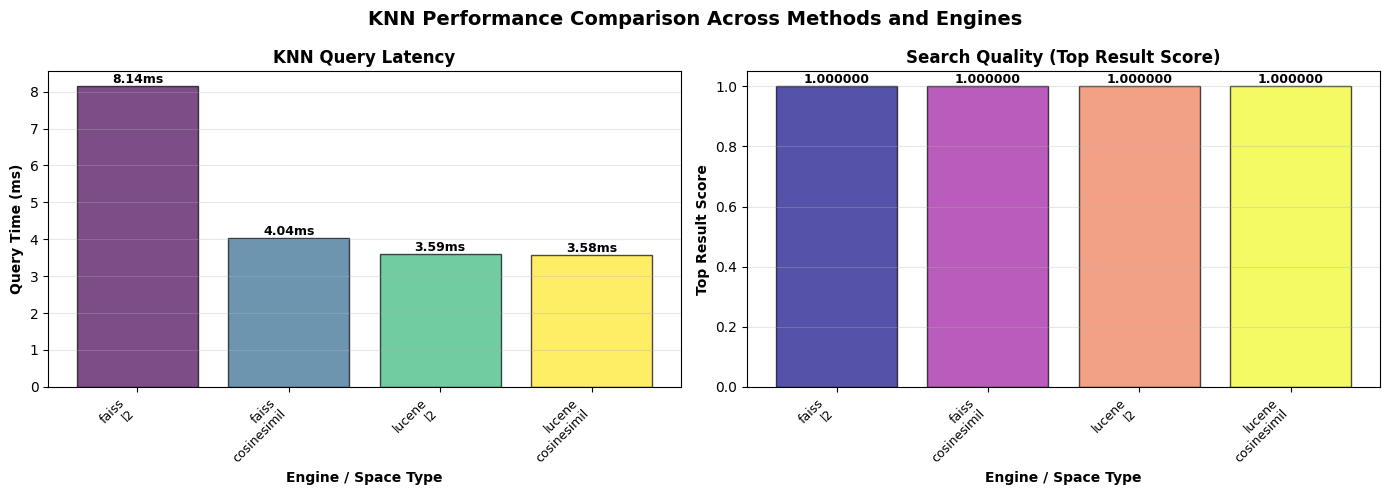

✓ Visualization generated!


In [9]:
# Visualization: Performance Comparison

print("\nGenerating Performance Visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('KNN Performance Comparison Across Methods and Engines', fontsize=14, fontweight='bold')

# Extract data for visualization
engines = []
query_times = []
top_scores = []

for index_name, result in search_results.items():
    config = next((c for c in created_indices if c['name'] == index_name), None)
    if config:
        engines.append(f"{config['engine']}\n{config['space_type']}")
        query_times.append(result['time_ms'])
        if result['hits']:
            top_scores.append(result['hits'][0]['_score'])

# Plot 1: Query Time
colors_time = plt.cm.viridis(np.linspace(0, 1, len(engines)))
axes[0].bar(range(len(engines)), query_times, color=colors_time, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Engine / Space Type', fontweight='bold')
axes[0].set_ylabel('Query Time (ms)', fontweight='bold')
axes[0].set_title('KNN Query Latency', fontweight='bold')
axes[0].set_xticks(range(len(engines)))
axes[0].set_xticklabels(engines, rotation=45, ha='right', fontsize=9)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (eng, time) in enumerate(zip(engines, query_times)):
    axes[0].text(i, time, f'{time:.2f}ms', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: Top Result Scores
colors_score = plt.cm.plasma(np.linspace(0, 1, len(engines)))
axes[1].bar(range(len(engines)), top_scores, color=colors_score, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Engine / Space Type', fontweight='bold')
axes[1].set_ylabel('Top Result Score', fontweight='bold')
axes[1].set_title('Search Quality (Top Result Score)', fontweight='bold')
axes[1].set_xticks(range(len(engines)))
axes[1].set_xticklabels(engines, rotation=45, ha='right', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (eng, score) in enumerate(zip(engines, top_scores)):
    axes[1].text(i, score, f'{score:.6f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Visualization generated!")


## Key Takeaways: Choosing the Right Method and Engine

### 📋 Decision Guide

**Choose HNSW if:**
- ✅ Query latency is critical
- ✅ Query quality is more important than memory
- ✅ You have enough RAM available
- ✅ No training phase is acceptable

**Choose IVF if:**
- ✅ Memory usage is a primary concern
- ✅ Acceptable for indexing latency to be slower
- ✅ Large datasets (100M+ vectors)
- ✅ Can afford the training phase
- ✅ Can tolerate slightly lower query quality

**Choose Faiss if:**
- ✅ Large-scale deployments (> 10 million vectors)
- ✅ Lowest indexing latency is needed
- ✅ Need advanced features (IVF, encoders, GPU support)
- ✅ Tens of billions of vectors

**Choose Lucene if:**
- ✅ Smaller deployments (< 10 million vectors)
- ✅ Need smart filtering capabilities
- ✅ Want tight OpenSearch integration
- ✅ Dataset fits in memory

---

### 🎓 Learning Objectives Achieved

Through this notebook, you've learned:

1. **Methods**: Difference between HNSW (hierarchical graphs) and IVF (partitioning)
2. **Engines**: How Faiss, Lucene, and NMSLIB implement these methods
3. **Configuration**: How to create indices with different methods and engines
4. **Performance**: How to benchmark and compare configurations
5. **Memory**: How to estimate and optimize memory usage
6. **Trade-offs**: Query latency vs. quality vs. memory vs. indexing speed

---

### 📚 Further Reading

- [OpenSearch KNN Documentation](https://docs.opensearch.org/latest/vector-search/)
- [Faiss GitHub](https://github.com/facebookresearch/faiss)
- [HNSW Paper](https://arxiv.org/abs/1603.09320)
- [Performance Tuning Guide](https://docs.opensearch.org/latest/vector-search/performance-tuning/)

---

### 💡 Best Practices

1. **Always normalize vectors** for cosinesimil and innerproduct metrics
2. **Start with HNSW** for new projects, switch to IVF if memory becomes an issue
3. **Monitor query latency** - aim for < 100ms for most applications
4. **Plan for scale** - memory grows with number of vectors
5. **Use encoders** (PQ, SQ) to reduce memory when needed
6. **Test with your actual data** - performance varies with data characteristics

